In [2]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

<b>Load the two datasets and combine them with concat() (into one big DataFrame)</b>

In [3]:
# if your data is in one file only, just load the df normally
df1 = pd.read_csv("DailyDelhiClimateTrain.csv")
df2 = pd.read_csv("DailyDelhiClimateTest.csv")

# combine the two files into one DataFrame
# NOTE! remember to reset index EVERY TIME
# you use concat
df = pd.concat([df1, df2])
df = df.reset_index()

In [4]:
df

,index,date,meantemp,humidity,wind_speed,meanpressure
0,0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...,...
1571,109,2017-04-20,34.500000,27.500000,5.562500,998.625000
1572,110,2017-04-21,34.250000,39.375000,6.962500,999.875000
1573,111,2017-04-22,32.900000,40.900000,8.890000,1001.600000
1574,112,2017-04-23,32.875000,27.500000,9.962500,1002.125000


In [5]:
df.describe()

,index,meantemp,humidity,wind_speed,meanpressure
count,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000
mean,681.746193,25.221918,60.445229,6.899262,1010.593178
std,442.630431,7.345014,16.979994,4.510725,175.242704
min,0.000000,6.000000,13.428571,0.000000,-3.041667
25%,279.750000,18.500000,49.750000,3.700000,1001.875000
50%,673.500000,27.166667,62.440476,6.363571,1009.055556
75%,1067.250000,31.142857,72.125000,9.262500,1015.200000
max,1461.000000,38.714286,100.000000,42.220000,7679.333333


In [6]:
# we need to process this data into a format, where meantemp is class = 0, and windspeed is class 1
# and all of the data is then shuffled
# and all the data splitted into timesteps (probably 50 as the step size?)

In [7]:
# for this example, let's take meantemp (temperature) and wind_speed 
# so we are going to make a signal detector, that detects if the signal
# is related to temperature or a wind event

In [8]:
# drop humidity and meanpressure, so that we are left with 
# meantemp and wind_speed
df = df.drop(["humidity", "meanpressure"], axis=1)

In [9]:
df.head()

,index,date,meantemp,wind_speed
0,0,2013-01-01,10.000000,0.000000
1,1,2013-01-02,7.400000,2.980000
2,2,2013-01-03,7.166667,4.633333
3,3,2013-01-04,8.666667,1.233333
4,4,2013-01-05,6.000000,3.700000


In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [11]:
num_cols = ["meantemp", "wind_speed"]
df[num_cols] = scaler.fit_transform(df[num_cols])

In [12]:
df.head()

,index,date,meantemp,wind_speed
0,0,2013-01-01,0.122271,0.000000
1,1,2013-01-02,0.042795,0.070583
2,2,2013-01-03,0.035662,0.109743
3,3,2013-01-04,0.081514,0.029212
4,4,2013-01-05,0.000000,0.087636


In [13]:
# for easier management, let's change the date
# into a sequence number starting from 1 to X
# NOTE! BEFORE THIS, CHECK THAT YOUR DATE IS IN ASCENDING ORDER

In [14]:
df["sequence"] = df.index + 1
df = df.drop(["date", "index"], axis=1)

In [15]:
df.describe()

,meantemp,wind_speed,sequence
count,1576.000000,1576.000000,1576.000000
mean,0.587570,0.163412,788.500000
std,0.224520,0.106839,455.096327
min,0.000000,0.000000,1.000000
25%,0.382096,0.087636,394.750000
50%,0.647016,0.150724,788.500000
75%,0.768559,0.219387,1182.250000
max,1.000000,1.000000,1576.000000


In [16]:
df.tail()

,meantemp,wind_speed,sequence
1571,0.871179,0.131750,1572
1572,0.863537,0.164910,1573
1573,0.822271,0.210564,1574
1574,0.821507,0.235966,1575
1575,0.794760,0.287947,1576


<b>Now we should have sequence number, meantemp and wind_speed left in the DataFrame</b>

In [17]:
# we have to divide this data into timesteps
# we have ~1500 points of data
# we could use 50 points as the timestep
# we are going to use the names of variables 
# as the output class type (0 or 1)

# use pandas.melt() to flip the DataFrame into a more suitable format
df = pd.melt(df, id_vars=["sequence"], value_vars=["meantemp", "wind_speed"],
             var_name="class", value_name="measurement")

In [18]:
# now our data is separated by the variable 
# each column has a row for each sequence number and measurement 
# this allows us to process the data as separate signals
df.head(10)

,sequence,class,measurement
0,1,meantemp,0.122271
1,2,meantemp,0.042795
2,3,meantemp,0.035662
3,4,meantemp,0.081514
4,5,meantemp,0.000000
5,6,meantemp,0.030568
6,7,meantemp,0.030568
7,8,meantemp,0.087336
8,9,meantemp,0.244541
9,10,meantemp,0.152838


In [19]:
# we have 1576 data points for temperature
df[df['class'] == "meantemp"]

,sequence,class,measurement
0,1,meantemp,0.122271
1,2,meantemp,0.042795
2,3,meantemp,0.035662
3,4,meantemp,0.081514
4,5,meantemp,0.000000
...,...,...,...
1571,1572,meantemp,0.871179
1572,1573,meantemp,0.863537
1573,1574,meantemp,0.822271
1574,1575,meantemp,0.821507


In [20]:
# we have 1576 data points for wind as well
df[df['class'] == "wind_speed"]

,sequence,class,measurement
1576,1,wind_speed,0.000000
1577,2,wind_speed,0.070583
1578,3,wind_speed,0.109743
1579,4,wind_speed,0.029212
1580,5,wind_speed,0.087636
...,...,...,...
3147,1572,wind_speed,0.131750
3148,1573,wind_speed,0.164910
3149,1574,wind_speed,0.210564
3150,1575,wind_speed,0.235966


In [21]:
# replace the original variable names into target output variable
# values => 0 or 1, depending if the signal is temperature or wind
df['class'] = df['class'].replace({"meantemp": 0, "wind_speed": 1})

C:\Users\tomco\AppData\Local\Temp\ipykernel_30268\412533073.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['class'] = df['class'].replace({"meantemp": 0, "wind_speed": 1})


In [22]:
# MAKE THIS PRETTIER, THIS IS QUICK AND DIRTY
class_names = np.array(["meantemp", "wind_speed"])
num_classes = len(class_names)
classes = [0, 1]


In [23]:
# we have to split the DataFrame into separate DataFrames
# based on their target variable
df_class_1 = df[df['class'] == 0]
df_class_2 = df[df['class'] == 1]

# combine into a list for easier iteration
# WHEN WE DO THE TIMESTEP SPLIT
splitted_dfs = [df_class_1, df_class_2]

In [24]:
df_class_1['class'].value_counts()

class
0    1576
Name: count, dtype: int64

In [25]:
df_class_2['class'].value_counts()

class
1    1576
Name: count, dtype: int64

In [26]:
df

,sequence,class,measurement
0,1,0,0.122271
1,2,0,0.042795
2,3,0,0.035662
3,4,0,0.081514
4,5,0,0.000000
...,...,...,...
3147,1572,1,0.131750
3148,1573,1,0.164910
3149,1574,1,0.210564
3150,1575,1,0.235966


<b>For each signal type, we have to split them into 50 point chunks and save them into a list</b>

In [27]:
# 1575 points, anything after this is discarded

max_size = 1575
time_step_size = 45
x_total = []
y_total = []

# built x_total and y_total for all categories (2 at this point)
for category in classes:
    # we will start cutting the original signal data
    # starting from index 0
    index_cutoff = 0

    while index_cutoff / max_size < 1:
        timestep = []

        # take a slice of 50 points, starting from cutoff until cutoff + 45
        slice = splitted_dfs[category].iloc[index_cutoff:index_cutoff + time_step_size]
    
        # take a slice of selected category / signal type
        # and place it in x_total and y_total
        x_total.append(list(slice['measurement']))
        y_total.append(category)

        # after each slicing operation, increase the cutoff
        # by 45 (step size), otherwise we get an infinite
        index_cutoff += time_step_size


In [28]:
len(x_total)

70

In [29]:
len(y_total)

70

In [30]:
# this signal has 45 points
x_total[55]

[0.3073188062529607,
 0.1921482709616296,
 0.10421601136901944,
 0.14240881099005215,
 0.1539554713405969,
 0.14833017527238276,
 0.2738630980577925,
 0.33426101373756517,
 0.21405731880625298,
 0.2738630980577926,
 0.2359663666508764,
 0.09888678351492186,
 0.16461392704879205,
 0.3398863098057793,
 0.400284225485552,
 0.3319347634837924,
 0.2196826148744671,
 0.04381809568924681,
 0.06572714353387021,
 0.060397915679772624,
 0.14270487920416866,
 0.07668166745618192,
 0.1758645191852203,
 0.11517053529133113,
 0.25757934628138324,
 0.4059095215537661,
 0.3182733301752724,
 0.10421601136901944,
 0.09888678351492185,
 0.016579819990525817,
 0.11517053529133113,
 0.1924443391757461,
 0.1865229748934155,
 0.2031027948839413,
 0.15898863098057794,
 0.47163666508763624,
 0.39998815727143533,
 0.26853387020369496,
 0.2744552344860256,
 0.25757934628138324,
 0.2359663666508764,
 0.09888678351492186,
 0.021909047844623403,
 0.060397915679772624,
 0.12612505921364284]

In [31]:
y_total[55]

1

In [32]:
# we have 70 timesteps or pieces of signal
len(x_total)

70

In [33]:
# each piece of signal, has 45 points
len(x_total[0])

45

In [34]:
# 45 * 70
# remember: we used 1575 signals for 2 categories =
# 2 * 1575 = 3150
45 * 70

3150

In [35]:
# randomize the data, because now they are in order
# by the target variable, which is a problem for a neural network

# shuffle the data so that we don't 
# break the pairings between x_total and y_total
import random
zipped = list(zip(x_total, y_total))
random.shuffle(zipped)
x_total, y_total = zip(*zipped)

In [36]:
y_total[6]

1

In [37]:
#x_total[2]

In [38]:
x_total = np.array(x_total)
y_total = np.array(y_total)

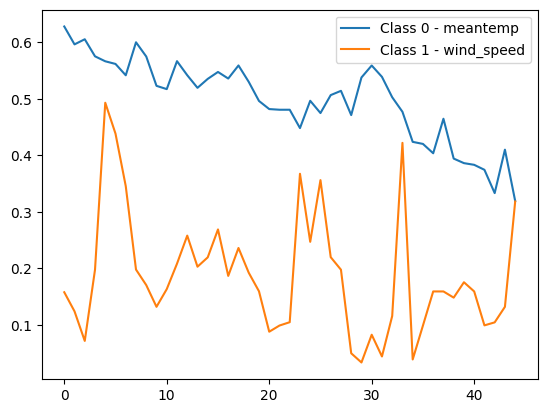

In [39]:
c_x_train = x_total[y_total == 0]
plt.plot(c_x_train[4], label="Class 0 - meantemp")

c_x_train = x_total[y_total == 1]
plt.plot(c_x_train[4], label="Class 1 - wind_speed")
plt.legend()

In [40]:
# Finally! We can do the train/test split
# let's make a helper variable to split the dataset
train_size = 0.7
splitter = int(len(x_total) * train_size)

x_train = x_total[0:splitter]
x_test = x_total[splitter:]
y_train = y_total[0:splitter]
y_test = y_total[splitter:]

#ALWAYS CHECK THAT THE AMOUNTS MATCH WITH THE SPLIT AND ORIGINAL DATA
# splitter <- the part where the train/test -split is cutoff
# print(len(x_train))
# print(len(x_test))
# print(len(y_train))
# print(len(y_test))

In [41]:
# The data format BEFORE reshaping!
# note: array with two levels of lists inside
x_train

array([[0.26912601, 0.36340259, 0.29073899, ..., 0.07697774, 0.07135244,
        0.20310279],
       [0.58460699, 0.5731441 , 0.60371179, ..., 0.76419214, 0.76037118,
        0.79858079],
       [0.03286357, 0.03848887, 0.08230696, ..., 0.27978446, 0.16994315,
        0.21909048],
       ...,
       [0.42603712, 0.38311499, 0.34770742, ..., 0.86353712, 0.82227074,
        0.82150655],
       [0.20251092, 0.22543668, 0.22161572, ..., 0.50054585, 0.56932314,
        0.58460699],
       [0.01894837, 0.07135244, 0.08230696, ..., 0.13707958, 0.8168522 ,
        0.10421601]])

In [42]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [43]:
# the data format AFTER reshaping!
# note: one more dimension of list added
x_train

array([[[0.26912601],
        [0.36340259],
        [0.29073899],
        ...,
        [0.07697774],
        [0.07135244],
        [0.20310279]],

       [[0.58460699],
        [0.5731441 ],
        [0.60371179],
        ...,
        [0.76419214],
        [0.76037118],
        [0.79858079]],

       [[0.03286357],
        [0.03848887],
        [0.08230696],
        ...,
        [0.27978446],
        [0.16994315],
        [0.21909048]],

       ...,

       [[0.42603712],
        [0.38311499],
        [0.34770742],
        ...,
        [0.86353712],
        [0.82227074],
        [0.82150655]],

       [[0.20251092],
        [0.22543668],
        [0.22161572],
        ...,
        [0.50054585],
        [0.56932314],
        [0.58460699]],

       [[0.01894837],
        [0.07135244],
        [0.08230696],
        ...,
        [0.13707958],
        [0.8168522 ],
        [0.10421601]]])

In [44]:
# model with 3 convolutional layers + the rest of the neural network
def make_model(input_shape):
    model = keras.Sequential(
        [
            keras.layers.Input(input_shape),
            keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),

            keras.layers.GlobalAveragePooling1D(),
            keras.layers.Flatten(),
            keras.layers.Dense(64, activation="relu"),
            
            keras.layers.Dense(num_classes, activation="softmax")

        ]
    )

    return model

model = make_model(input_shape=x_train.shape[1:])

In [45]:
epochs = 500
batch_size = 8

# useful callbacks typically for time series
# or CNN in general
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss"
    ),
]

# usual combination
# this example uses sparse categorical crossentropy
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

# train the model
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)


Epoch 1/500




5/5 [==============================] - 2s 88ms/step - loss: 0.5361 - sparse_categorical_accuracy: 0.6923 - val_loss: 0.6668 - val_sparse_categorical_accuracy: 0.6000
Epoch 2/500
5/5 [==============================] - 0s 22ms/step - loss: 0.4013 - sparse_categorical_accuracy: 0.9231 - val_loss: 0.6567 - val_sparse_categorical_accuracy: 0.6000
Epoch 3/500
5/5 [==============================] - 0s 34ms/step - loss: 0.3257 - sparse_categorical_accuracy: 0.9231 - val_loss: 0.6463 - val_sparse_categorical_accuracy: 0.6000
Epoch 4/500
5/5 [==============================] - 0s 27ms/step - loss: 0.2878 - sparse_categorical_accuracy: 0.8974 - val_loss: 0.6373 - val_sparse_categorical_accuracy: 0.6000
Epoch 5/500
5/5 [==============================] - 0s 23ms/step - loss: 0.3322 - sparse_categorical_accuracy: 0.9231 - val_loss: 0.6281 - val_sparse_categorical_accuracy: 0.7000
Epoch 6/500
5/5 [==============================] - 0s 27ms/step - loss: 0.2706 - sparse_categorical_accuracy: 0.8462 - va

<Axes: >

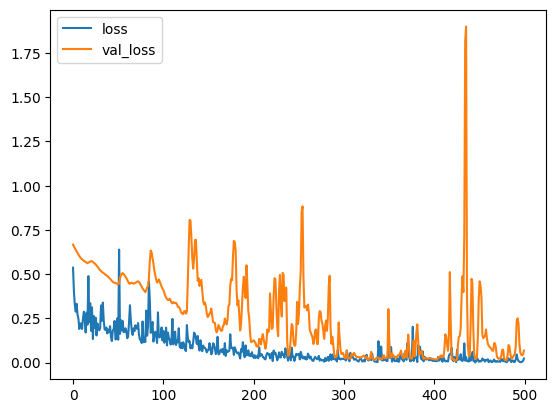

In [46]:
loss_df = pd.DataFrame(model.history.history)
loss_df[["loss", "val_loss"]].plot()

<Axes: >

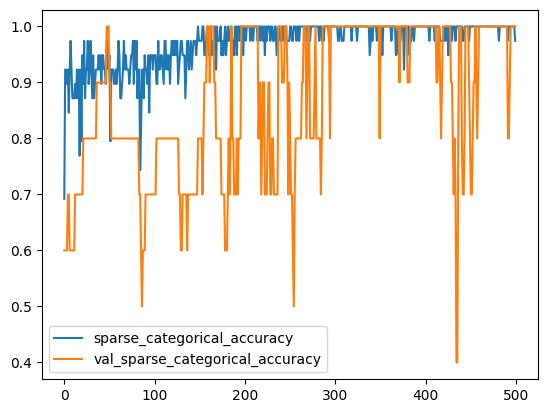

In [47]:
loss_df[["sparse_categorical_accuracy", "val_sparse_categorical_accuracy"]].plot()

In [48]:
 # load up the best version of the model
model = keras.models.load_model("best_model.keras")

# evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

1/1 [==============================] - 0s 327ms/step - loss: 0.0710 - sparse_categorical_accuracy: 0.9524
Test accuracy 0.9523809552192688
Test loss 0.07095100730657578


In [49]:
# make predictions and use argmax
test_predictions = model.predict(x_test)
test_predictions = np.argmax(test_predictions, axis=1)

1/1 [==============================] - 0s 114ms/step


<Axes: >

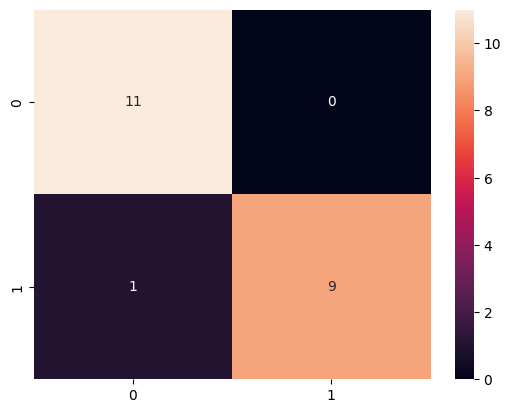

In [50]:
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g')

In [51]:
 # print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.90      0.95        10

    accuracy                           0.95        21
   macro avg       0.96      0.95      0.95        21
weighted avg       0.96      0.95      0.95        21


Model overall accuracy: 95.24%


In [52]:
 # roc auc score also very good
roc_auc_score(y_test, model.predict(x_test)[:, 1])

1/1 [==============================] - 0s 39ms/step


1.0

0
meantemp


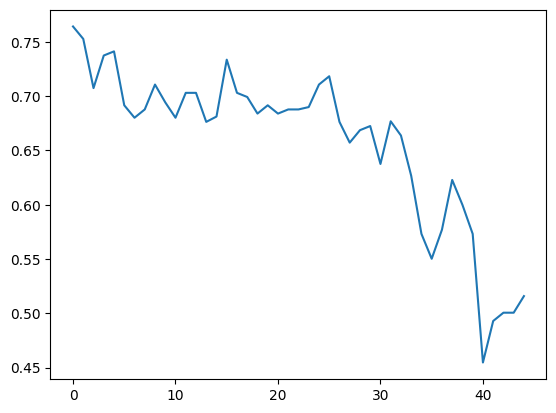

In [53]:
 # plot the figure for this signal
signal_index = 8
print(y_test[signal_index])
print(class_names[y_test[signal_index]])
plt.figure()
plt.plot(x_test[signal_index])
plt.show()

0
meantemp


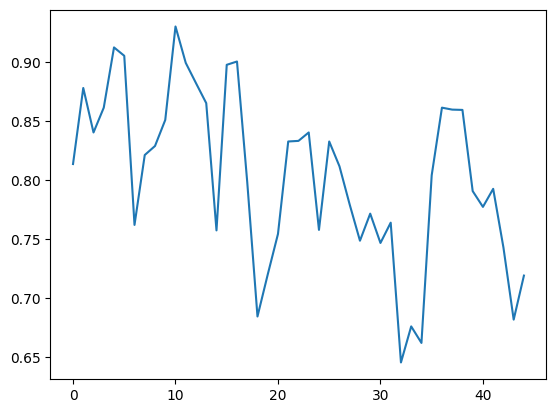

In [54]:
 # plot the figure for this signal
signal_index = 12
print(y_test[signal_index])
print(class_names[y_test[signal_index]])
plt.figure()
plt.plot(x_test[signal_index])
plt.show()


<Axes: >

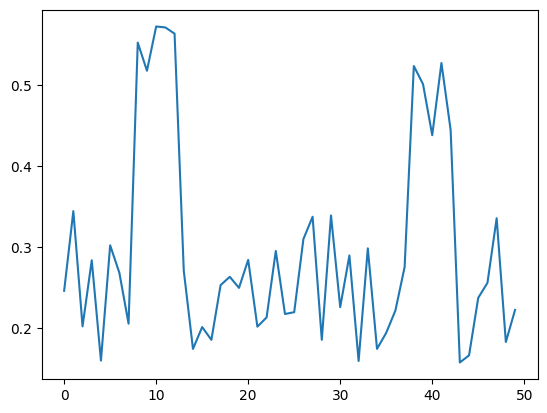

In [55]:
# THIS WAS ASKED FROM CHATGPT
# SINCE IT'S QUITE TIME CONSUMING TO DO BY HAND

# Generate x values from 0 to 49
x_values = np.arange(50)

# Generate y values fluctuating between 0.15 and 0.25
y_values = np.random.uniform(0.15, 0.35, size=50)

# Insert spikes for y values towards 0.5
y_values[8:13] = 0.5  # Spike 1, centered around index 10, 5 points wide
y_values[38:43] = 0.5 # Spike 2, centered around index 40, 5 points wide

# Add small random fluctuation to the spikes
y_values[8:13] += np.random.uniform(-0.075, 0.075, size=5)
y_values[38:43] += np.random.uniform(-0.075, 0.075, size=5)

# Ensure values stay within the range [0, 1]
y_values = np.clip(y_values, 0, 1)

# 
sns.lineplot(x=x_values, y=y_values)

In [56]:
y_test[11]

0

In [57]:
points = y_values
test_signal = np.expand_dims(points, axis=1)
test_batch = np.array([test_signal])
#result = model.predict([x_test[11]])[0]
test_predict = model.predict(test_batch)

# print prediction results
print(test_predict)
index = np.argmax(test_predict)
print(class_names[index])

1/1 [==============================] - 0s 101ms/step
[[0.04927938 0.9507206 ]]
wind_speed


In [58]:
# seems to match
result = model.predict([x_test[8]])[0]
index = np.argmax(result)
print(class_names[index])

2/2 [==============================] - 0s 3ms/step
wind_speed


<Axes: >

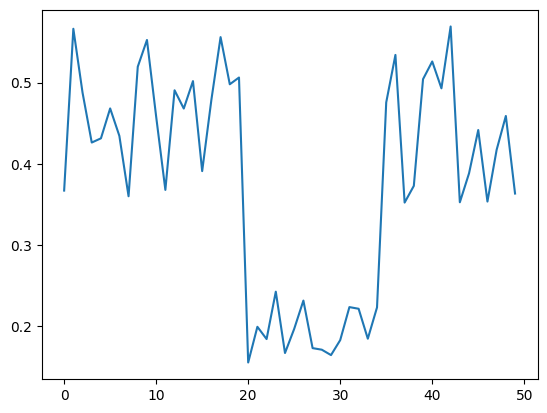

In [59]:
 # Define the range of x-values
x = np.arange(50)

# Define the fluctuation ranges for y-values
y_min = 0.35
y_max = 0.57

# Create y-values with fluctuation
y = np.random.uniform(y_min, y_max, len(x))

# Create a pit in the y-values
pit_start = 20
pit_end = pit_start + 15
y[pit_start:pit_end] = np.random.uniform(0.15, 0.25, pit_end - pit_start)

sns.lineplot(x=x, y=y)

In [60]:
points = y
test_signal = np.expand_dims(points, axis=1)
test_batch = np.array([test_signal])
# result = model.predict([x_test[12]])[0]
test_predict = model.predict(test_batch)

# print prediction results
print(test_predict)
index = np.argmax(test_predict)
print(class_names[index])

1/1 [==============================] - 0s 33ms/step
[[0.9936225  0.00637748]]
meantemp


In [61]:
# seems to match
result = model.predict([x_test[1]])[0]
index = np.argmax(result)
print(result)
print(class_names[index])

2/2 [==============================] - 0s 5ms/step
[0.88833857 0.11166143]
meantemp


In [64]:
# For some reason the above cell can make the kernel crash if x_test[] is not wrapped in additional square brackets
#print(x_test[1])
print([x_test[1]])

[array([[0.02921206],
       [0.13162347],
       [0.10015565],
       [0.1509102 ],
       [0.17574609],
       [0.17527238],
       [0.16066635],
       [0.04944339],
       [0.0438181 ],
       [0.03755837],
       [0.        ],
       [0.13184904],
       [0.0940651 ],
       [0.10049401],
       [0.06902619],
       [0.01460603],
       [0.13162347],
       [0.08763619],
       [0.        ],
       [0.02503891],
       [0.        ],
       [0.05007782],
       [0.03671246],
       [0.03286357],
       [0.        ],
       [0.02753434],
       [0.02503891],
       [0.04405495],
       [0.01752724],
       [0.06039792],
       [0.11684826],
       [0.0940651 ],
       [0.05650673],
       [0.07303016],
       [0.02503891],
       [0.10984131],
       [0.13175036],
       [0.05842413],
       [0.        ],
       [0.0754551 ],
       [0.10658456],
       [0.47163667],
       [0.01251946],
       [0.05842413],
       [0.13771402]])]
